In [1]:
import sys
sys.path.append('/mnt/nas/minici/UrbRecLoop')


In [2]:
%cd /mnt/nas/minici/UrbRecLoop

/mnt/nas/minici/UrbRecLoop


/home/minici/anaconda3/envs/frasson/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
from model.recommender3 import MultiVAE, MatrixFactorization
from model import user
from datetime import timedelta
import glob
import tqdm
import os
import pandas as pd
import numpy as np

def filtering_training_data(training_dataset, min_activity):
    # Count the number of rows per user
    user_counts = training_dataset['uid'].value_counts()
    # Get the users with at least x rows
    valid_users = user_counts[user_counts >= min_activity].index
    # Filter the DataFrame to include only valid users
    filtered_dataset = training_dataset[training_dataset['uid'].isin(valid_users)]
    return filtered_dataset

def create_interaction_matrix(data):
    interaction_counts = data.groupby(['uid', 'venueID']).size().reset_index(name='counts')
    interaction_matrix = interaction_counts.pivot(index='uid', columns='venueID', values='counts').fillna(0)
    return interaction_matrix


def calculate_metrics(recommended_venues, real_visited_venues):
    recommended_venues = list(recommended_venues)
    real_visited_venues = set(real_visited_venues)

    # Calculate hits
    hits = [1 if venue in real_visited_venues else 0 for venue in recommended_venues]

    # Precision
    precision = sum(hits) / len(recommended_venues) if recommended_venues else 0

    # Recall
    recall = sum(hits) / len(real_visited_venues) if real_visited_venues else 0

    # NDCG
    dcg = 0
    idcg = 0
    for i, hit in enumerate(hits, 1):
        if hit:
            dcg += 1 / np.log2(i + 1)
    for i in range(1, len(real_visited_venues) + 1):
        idcg += 1 / np.log2(i + 1)
    ndcg = dcg / idcg if idcg > 0 else 0

    # MRR
    mrr = 0
    for i, hit in enumerate(hits, 1):
        if hit:
            mrr = 1 / i
            break

    # Hit Rate
    hit_rate = 1 if any(hits) else 0

    return {
        'ndcg': ndcg,
        'precision': precision,
        'recall': recall,
        'mrr': mrr,
        'hitrate': hit_rate
    }


In [4]:
# DATASET HYPER-PARAMETERS #
city = "nyc"
city_files = glob.glob('*_visits.csv')
data_file = f"./data/processed/foursquare_complete_{city}_cp_small.csv"
train_window = 60  # Training window in days
k_days = 7  # Epoch length in days
threshold = 100  # Performance degradation threshold (adjust as needed)
max_simulation_days = 90  # Maximum number of simulation days
min_activity = 5  
topK = 20

# RECSYS HYPER-PARAMETERS #
# MF
num_latent_factors = 32
# UserKNN
num_nearest_neighbors = 5


In [5]:
# DATA LOADING
dataset = pd.read_csv(data_file)
print(f'Dataset has {len(dataset)} records.')
dataset['time'] = pd.to_datetime(dataset['time'])
dataset['uid'] = dataset['uid'].astype(int)
dataset['venueID'] = dataset['venueID'].astype(str)
#drop duplicates
dataset = dataset.drop_duplicates()
# self.city_name = os.path.basename(data_file).split('_')[0]
print(f'Dataset has {len(dataset)} records after removing duplicates.')
# Set training period
start_date = dataset['time'].min()
training_duration = timedelta(days=train_window)
t = start_date + training_duration
# Training data
train_data = dataset[dataset['time'] < t]
# Filtering out users with few interactions (visited less than X POIs)
train_data = filtering_training_data(train_data, min_activity)
# Simulation data==Test data
test_data = dataset[dataset['time'] >= t]
# Excluding users not present in the training dataset
test_data = test_data[test_data['uid'].isin(train_data['uid'].unique())]
test_data = test_data[test_data['venueID'].isin(train_data['venueID'].unique())]
# Prepare interaction matrix
X_train = create_interaction_matrix(train_data)


Dataset has 50000 records.
Dataset has 49950 records after removing duplicates.


In [13]:
from model.recommender3 import BPRMF
import torch
import torch.nn.functional as F

def bpr_loss(user_factors, pos_item_factors, neg_item_factors, reg_lambda=0.0):
    """
    Computes the BPR loss given user, positive, and negative item factors.
    - user_factors: tensor of shape [batch_size, latent_dim]
    - pos_item_factors: tensor of shape [batch_size, latent_dim]
    - neg_item_factors: tensor of shape [batch_size, latent_dim]
    - reg_lambda: regularization coefficient for L2 regularization
    """
    diff = (user_factors * (pos_item_factors - neg_item_factors)).sum(dim=1)
    loss = -torch.log(torch.sigmoid(diff) + 1e-8).mean()  # epsilon to avoid log(0)

    if reg_lambda > 0:
        reg_loss = reg_lambda * (user_factors.norm(2).pow(2) +
                                 pos_item_factors.norm(2).pow(2) +
                                 neg_item_factors.norm(2).pow(2)) / user_factors.shape[0]
        loss += reg_loss
    return loss

num_users, num_items = X_train.shape
recommender = BPRMF(num_users, num_items, 128, epochs=500, lr=0.001,
                 batch_size=128, patience=5, reg_lambda=0.001, device='cpu')


In [19]:
!pwd

/mnt/nas/minici/UrbRecLoop


In [21]:
mockdata = pd.read_csv('./data/processed/training_data_city_nyc-full__trainWindow_210__.csv')
mockdata.uid.nunique()

827

In [14]:
# Map users and items to indices
recommender.user_index = {user: idx for idx, user in enumerate(X_train.index)}
recommender.item_index = {item: idx for idx, item in enumerate(X_train.columns)}

# Fill missing values and convert the DataFrame to a numpy array.
data_matrix = X_train.fillna(0).values.astype(np.float32)
data_matrix[data_matrix > 0] = 1.0
recommender.user_item_matrix = torch.FloatTensor(data_matrix).to(recommender.device)

input_dim = recommender.user_item_matrix.shape[1]

# Precompute positive items per user and weighted negative sampling distributions.
user_pos_items = {}
for u in range(recommender.num_users):
    pos_items = np.where(recommender.user_item_matrix[u] > 0)[0]
    user_pos_items[u] = pos_items

    # Create weights: default weight 1 for all items.
    weights = np.ones(recommender.num_items, dtype=np.float32)
    weights[pos_items] = 0.0  # zero out positive items.
    weight_sum = weights.sum()
    if weight_sum > 0:
        weights /= weight_sum
    else:
        weights = np.ones(recommender.num_items, dtype=np.float32) / recommender.num_items
    recommender.user_neg_weights[u] = weights


In [15]:
best_loss = float('inf')
epochs_without_improvement = 0
loss_list = []

recommender.user_embedding.train()
recommender.item_embedding.train()

num_triplets_per_user = 4  # generate 4 triplets per user.

for epoch in range(recommender.epochs):
    triplet_users = []
    triplet_pos = []
    triplet_neg = []

    # Generate triplets for all users.
    for u in range(recommender.num_users):
        pos_items = user_pos_items[u]
        if len(pos_items) == 0:
            continue  # skip users with no positive interactions.
        for _ in range(num_triplets_per_user):
            pos_item = np.random.choice(pos_items)
            neg_item = np.random.choice(np.arange(recommender.num_items), p=recommender.user_neg_weights[u])
            triplet_users.append(u)
            triplet_pos.append(pos_item)
            triplet_neg.append(neg_item)

    if len(triplet_users) == 0:
        break  # no training samples available.

    # Shuffle triplets.
    triplets = list(zip(triplet_users, triplet_pos, triplet_neg))
    np.random.shuffle(triplets)
    triplet_users, triplet_pos, triplet_neg = zip(*triplets)
    triplet_users = np.array(triplet_users)
    triplet_pos = np.array(triplet_pos)
    triplet_neg = np.array(triplet_neg)

    epoch_loss = 0.0
    num_batches = int(np.ceil(len(triplet_users) / recommender.batch_size))

    # Process mini-batches.
    for i in range(num_batches):
        start = i * recommender.batch_size
        end = min((i + 1) * recommender.batch_size, len(triplet_users))
        batch_users = torch.LongTensor(triplet_users[start:end]).to(recommender.device)
        batch_pos = torch.LongTensor(triplet_pos[start:end]).to(recommender.device)
        batch_neg = torch.LongTensor(triplet_neg[start:end]).to(recommender.device)

        # Lookup embeddings.
        u_factors = recommender.user_embedding(batch_users)
        pos_factors = recommender.item_embedding(batch_pos)
        neg_factors = recommender.item_embedding(batch_neg)

        loss = bpr_loss(u_factors, pos_factors, neg_factors, recommender.reg_lambda)

        recommender.optimizer.zero_grad()
        loss.backward()
        recommender.optimizer.step()

        epoch_loss += loss.item()

    # Average loss per epoch.
    avg_epoch_loss = epoch_loss / num_batches
    loss_list.append(avg_epoch_loss)
    if avg_epoch_loss < best_loss:
        best_loss = avg_epoch_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    # Optionally print training loss.
    print(f"Epoch {epoch+1}/{recommender.epochs}, Loss: {avg_epoch_loss:.4f}")

    if epochs_without_improvement >= recommender.patience:
        # print(f"Stopping early at epoch {epoch+1} with best loss {best_loss:.4f}")
        break



Epoch 1/500, Loss: 0.6931
Epoch 2/500, Loss: 0.6928
Epoch 3/500, Loss: 0.6923
Epoch 4/500, Loss: 0.6918
Epoch 5/500, Loss: 0.6911
Epoch 6/500, Loss: 0.6905
Epoch 7/500, Loss: 0.6892
Epoch 8/500, Loss: 0.6881
Epoch 9/500, Loss: 0.6865
Epoch 10/500, Loss: 0.6846
Epoch 11/500, Loss: 0.6823
Epoch 12/500, Loss: 0.6796
Epoch 13/500, Loss: 0.6765
Epoch 14/500, Loss: 0.6726
Epoch 15/500, Loss: 0.6686
Epoch 16/500, Loss: 0.6629
Epoch 17/500, Loss: 0.6592
Epoch 18/500, Loss: 0.6528
Epoch 19/500, Loss: 0.6480
Epoch 20/500, Loss: 0.6421
Epoch 21/500, Loss: 0.6361
Epoch 22/500, Loss: 0.6276
Epoch 23/500, Loss: 0.6178
Epoch 24/500, Loss: 0.6117
Epoch 25/500, Loss: 0.6023
Epoch 26/500, Loss: 0.5946
Epoch 27/500, Loss: 0.5854
Epoch 28/500, Loss: 0.5752
Epoch 29/500, Loss: 0.5668
Epoch 30/500, Loss: 0.5568
Epoch 31/500, Loss: 0.5494
Epoch 32/500, Loss: 0.5414
Epoch 33/500, Loss: 0.5296
Epoch 34/500, Loss: 0.5214
Epoch 35/500, Loss: 0.5111
Epoch 36/500, Loss: 0.5017
Epoch 37/500, Loss: 0.4913
Epoch 38/5

/tmp/ipykernel_313778/3009594393.py:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


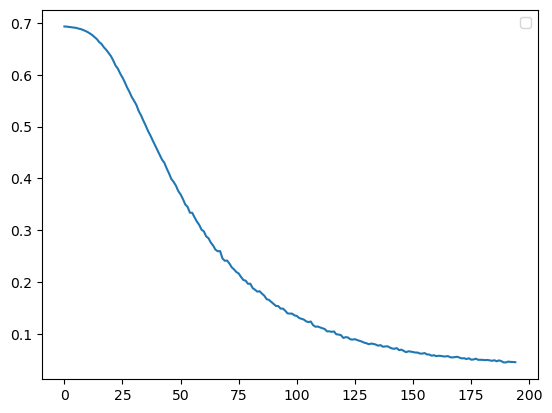

In [16]:
import matplotlib.pyplot as plt
plt.plot(loss_list)
plt.legend()
